In [1]:
import pickle as pkl
import numpy as np
from itertools import chain
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram, make_reliability_diagram_sklearn
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf, plot_weight_mixture, plot_forecast_pdf_i

2024-03-21 11:04:29.169593: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 11:04:29.196704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 11:04:29.196728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 11:04:29.197443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 11:04:29.201638: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 11:04:29.202076: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [3]:
ml_tn_gev_M13_STD1_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')
m_tn_gev_M13_STD1_C03 = load_model(folder + 'mixture/mixture_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

m_tn_ln_M13_STD1_C03 = load_model(folder + 'mixture/mixture_tn_ln_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')
ml_tn_ln_M13_STD1_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_ln_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

ml_tn_gev_M13_STD1 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_epochs600.pkl')

ml_tn_gev_M13_STD1_C02 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.019999999552965164_epochs600.pkl')

tn_M13_STD1_C03 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

ml_tn_gev_M13_STD4 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std4.0_epochs600.pkl')

tttt = {'ml_tn_gev_M13_STD1': ml_tn_gev_M13_STD1} #, 'ml_tn_gev_M13_STD1_C03':ml_tn_gev_M13_STD1_C03}

all_models_dict = {'base_model': base_model, 'ml_tn_gev_M13_STD1': ml_tn_gev_M13_STD1, 'm_tn_gev_M13_STD1_C03': m_tn_gev_M13_STD1_C03, 'm_tn_gev_M13_STD1_C03': m_tn_gev_M13_STD1_C03, 'm_tn_ln_M13_STD1_C03': m_tn_ln_M13_STD1_C03, 'ml_tn_ln_M13_STD1_C03': ml_tn_ln_M13_STD1_C03, 'ml_tn_gev_M13_STD1_C02': ml_tn_gev_M13_STD1_C02, 'tn_M13_STD1_C03': tn_M13_STD1_C03, 'ml_tn_gev_M13_STD4': ml_tn_gev_M13_STD4}

Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Gene

In [4]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.feature_names, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [5]:
for model_name, model in all_models_dict.items():
    print(model_name, model.forecast_distribution.has_negative_scale(X_test, variances_test))

base_model False
ml_tn_gev_M13_STD1 True
m_tn_gev_M13_STD1_C03 False
m_tn_ln_M13_STD1_C03 False
ml_tn_ln_M13_STD1_C03 False
ml_tn_gev_M13_STD1_C02 False
tn_M13_STD1_C03 False
ml_tn_gev_M13_STD4 False


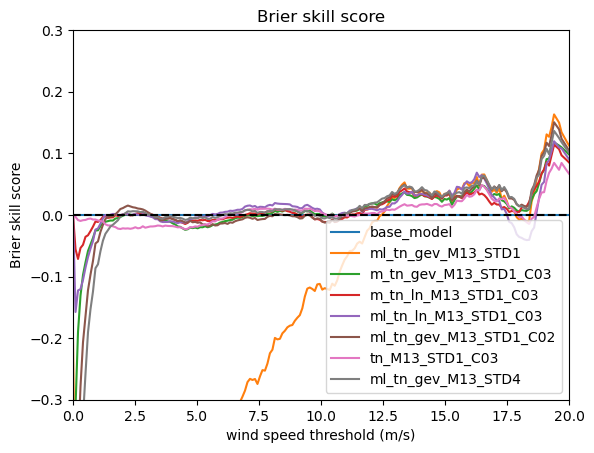

In [8]:
values = np.linspace(0, 20, 200)
ylim = [-0.3, 0.3]
brier_skill_plot(base_model, all_models_dict, X_test, y_test, variances_test, values, ylim=ylim)

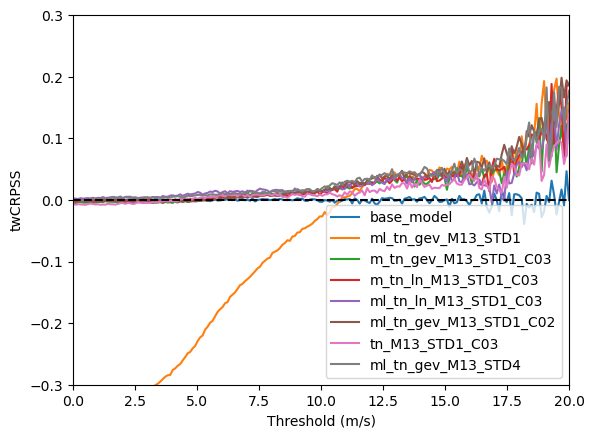

In [9]:
make_twcrpss_plot(base_model, all_models_dict, X_test, y_test, variances_test, values, ylim=ylim)

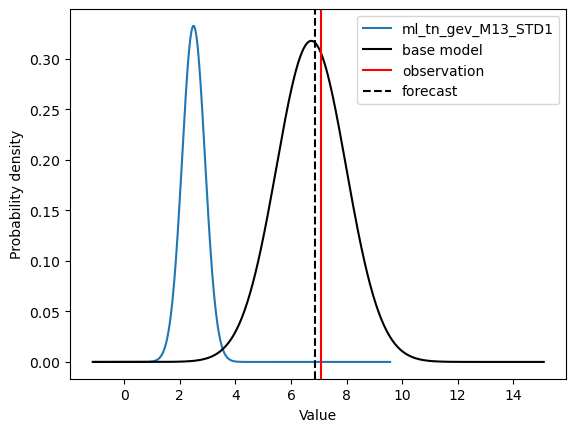

In [10]:
tttt = {'ml_tn_gev_M13_STD1': ml_tn_gev_M13_STD1} #, 'ml_tn_gev_M13_STD1_C03':ml_tn_gev_M13_STD1_C03}

observation_value = 10
plot_size = 8
# plot_forecast_pdf(tttt, X_test, y_test, variances_test, observation_value=observation_value, plot_size=plot_size, base_model=base_model)
i = 1802
plot_forecast_pdf_i(tttt, X_test, y_test, variances_test, i, plot_size=plot_size, base_model=base_model)

In [9]:
x = 18
print("Base model: ", base_model.loss_Brier_score(X_test, y_test, variances_test, x).numpy())
print("ml_tn_gev_M13_STD1_C03: ", ml_tn_gev_M13_STD1_C03.loss_Brier_score(X_test, y_test, variances_test, x).numpy())
print("ml_tn_gev_M13_STD1: ", ml_tn_gev_M13_STD1.loss_Brier_score(X_test, y_test, variances_test, x).numpy())

Base model:  0.0015424276
ml_tn_gev_M13_STD1_C03:  0.0015117595
ml_tn_gev_M13_STD1:  0.0043912646


In [10]:
x = 18
samples = 20000
print("Base model: ", base_model.loss_twCRPS_indicator_sample(X_test, y_test, variances_test, x, samples).numpy())
print("ml_tn_gev_M13_STD1_C03: ", ml_tn_gev_M13_STD1_C03.loss_twCRPS_indicator_sample(X_test, y_test, variances_test, x, samples).numpy())
print("ml_tn_gev_M13_STD1: ", ml_tn_gev_M13_STD1.loss_twCRPS_indicator_sample(X_test, y_test, variances_test, x, samples).numpy())

Base model:  0.0023941956
ml_tn_gev_M13_STD1_C03:  0.002183225
ml_tn_gev_M13_STD1:  0.0022072846


In [7]:
# plot a gev distr with loc, scale and conc as parameters using tfp
loc = 0
scale = -1
conc = 0.1
gev = tfp.distributions.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=conc)
n = 100

samples = gev.sample(n).numpy()
print(samples)




[ 0.29209962  0.37284872 -2.3255072  -0.17722243 -1.4896303  -0.44978145
  0.7534961   1.5195711   0.349626   -0.83653593 -1.8377837  -2.0595696
 -3.4300618  -0.04567101 -0.6858087  -8.007898    0.6193569   0.4695589
 -0.19780467  0.72073513  0.6433215  -1.157783   -2.5320559  -0.32448685
  0.18968739 -0.2871963  -1.6625487  -1.4690616  -0.6211946  -1.3718402
  0.22200847 -0.6052674   0.5871012  -0.09796624 -0.25163275 -1.3738211
  0.26565298 -0.37156716  0.7430137  -0.5916634   1.0119338   0.77270174
 -0.4538869   1.1011102  -1.0076562  -1.5511253  -0.090229   -1.6611403
 -0.4975581  -1.2248843  -0.78932357 -5.385898    0.4135549   0.8065299
 -1.0297202   0.5292638  -0.7404626  -1.1655836   0.4770255  -1.4528115
 -0.26362193 -0.48139036  0.48499912  0.5938709  -2.22324     0.35733795
 -0.22044346  0.4454807  -3.6450658   0.0258154  -2.2473366  -0.7455242
 -0.23694575 -1.4621415  -0.4866962  -0.19604746 -3.5460715  -3.1993296
 -1.0625801  -2.28182    -2.8357854  -4.4082036  -0.10657486